# Visualization and explore the Wildfire data with Matplotlib, Pandas and Seaborn

This notebook will connect to a MySQL DB in the cloud which houses a combined table for wild
fires in the US and weather conditions during each fire. Features will be evalauted for multicollinearity  usefulness in a model. The goal of the model is to predict the burn serverity based on the fire features and the weather. This notebook relies on the NASA fires dataset. 

In [3]:
#optional code if warnings become over bearing 
import warnings
warnings.filterwarnings('ignore')

### Getting Started:

In [4]:

%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import config #database connection variables 
from sqlalchemy import create_engine   #sql engine

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import yellowbrick as yb
from yellowbrick.features import RadViz
from yellowbrick.model_selection import LearningCurve

import pylab as pl
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler

### Connect to mySQL database in the cloud
Requires config files stored in the same directory as the notebook, contains the connection information 

Save the data to disk for faster access in the future


In [ ]:
def read_from_db() : 
    
    # create sqlalchemy engine
    engine = create_engine("mysql+mysqlconnector://{user}:{password}@{host}/{dbname}"
                       .format(user=config.db_user,
                               password=config.db_pass,
                               dbname=config.db_main,
                               host=config.db_host))
    
    #Create Query Statments

    queryFire = """
    SELECT *
    FROM Fire_Intensity_Model_Clean
    LIMIT 20000;
    """

    
    #Execute Queries
    df_fires = pd.read_sql(queryFire, engine)

    #close the database connection
    engine.dispose()
    
    
    df_fires.to_csv('data/fires.csv', index = False)
    
    

#### Read from to cloud db
Skip if reading from disk

In [ ]:
read_from_db()

### Read data from disk previously stored for faster access 

In [5]:
#Read the data from disk for faster access
df_fires = pd.read_csv('data/FireIntensity_Model_June12_Clean.csv')  #.sample(100000)

print(df_fires.shape)

(1328922, 26)


### Display the head of data for check.

In [6]:
print(df_fires.columns)

Index(['Unnamed: 0', 'latitude', 'longitude', 'doy', 'month', 'year',
       'cluster_reference', 'fire_region', 'season', 'covertype', 'fuelcode',
       'prefire_fuel', 'fuel_moisture_class', 'temperature', 'humidity',
       'precip_intensity', 'visibility', 'wind_speed', 'wind_gust',
       'brightness', 'fire_intensity', 'fire_intensity_twocat',
       'fire_intensity_threecat', 'fire_intensity_fourcat', 'bright_t31',
       'frp'],
      dtype='object')


### Drop Columns

<i> Drop columns not used, initial feature evaluation determined some columns could be y values such a bright_t31 or were duplicative  values </i>

In [7]:
#drop columns which are not relevant 

#remove index column if reading from cloud
df_fires = df_fires.drop(columns=['Unnamed: 0', 'year', 'cluster_reference', 'covertype', 
                                  'brightness', 'visibility', 'bright_t31', 'frp'])


### Visualize home many of each type of dependent variables we have (2)

We planned to predict 4 values but the models and data were only good at predicting 2 (Moderate and Severe)

Noted very small small Severe data count. 

Older note: Use seaborn to plot a count histogram. We have 4 separate categories.
1 (not burned), 2 (light), 3(med), 4 (heavy burn). We have a very uneven distribution. 
We will use SMOTE to fix this later.

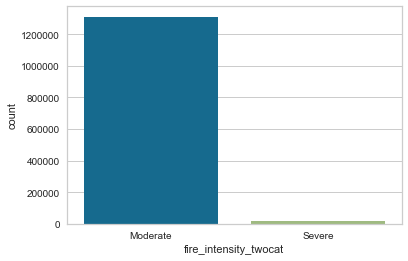

In [7]:
sns.countplot(df_fires['fire_intensity_twocat'],label="Count")
plt.show()

### Inspect the dataframe

In [8]:
# Expanding number of columns:
pd.set_option('display.max_columns', 40)

# review datagram
print (df_fires.shape)
df_fires.head(3)

(1328922, 18)


,latitude,longitude,doy,month,fire_region,season,fuelcode,prefire_fuel,fuel_moisture_class,temperature,humidity,precip_intensity,wind_speed,wind_gust,fire_intensity,fire_intensity_twocat,fire_intensity_threecat,fire_intensity_fourcat
0,34.5954,-78.6218,1,1,6,3,1600,6220.097576,3,64.14,0.88,0.011,6.42,12.51,Low,Moderate,Low,Low
1,33.4182,-110.8618,1,1,4,3,1220,4534.187262,2,32.17,0.37,0.000,6.88,18.50,Low,Moderate,Low,Low
2,29.7120,-95.1284,1,1,3,3,1,277.412850,2,65.97,0.50,0.000,10.98,16.90,Low,Moderate,Low,Low


### Draw box diagram to see scale and quartiles of data
We have scaling issues with 1-2 values that are on a large scale.
We will address when we down select and fine tune the models with scaling. 


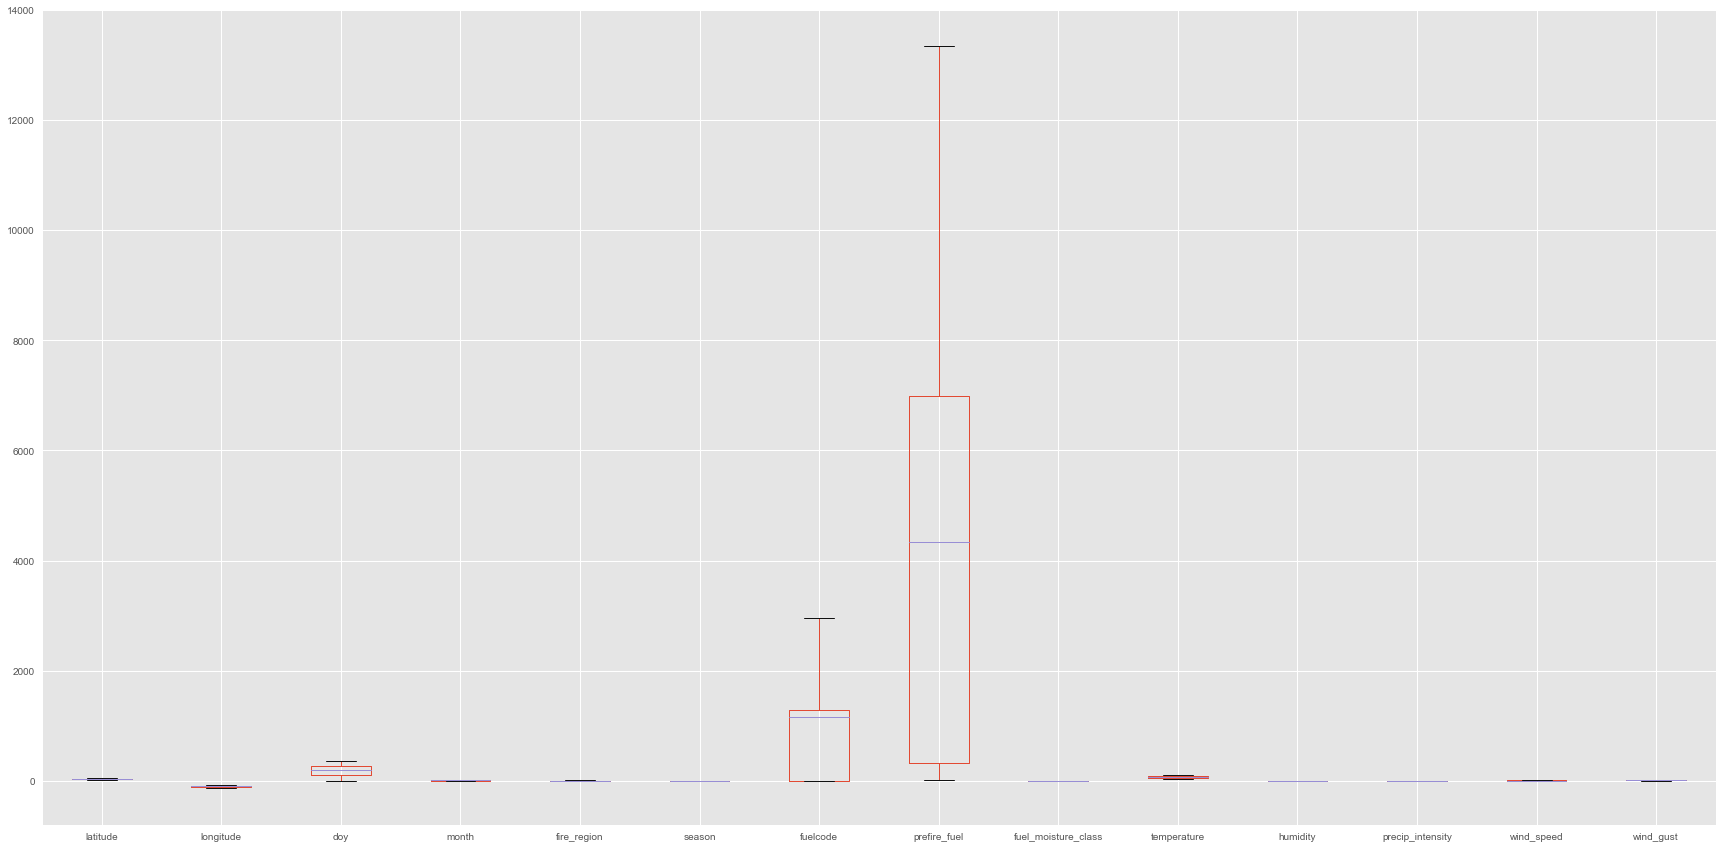

In [9]:
#draw box plot of see range of the data
import matplotlib
matplotlib.style.use('ggplot')
df_fires.plot(kind='box',figsize=(30,15))


### View histogram of all numerical data to better understand the distribution
Graphs show some data is continous while others are categorical. 
Not overly insightful for our model. 

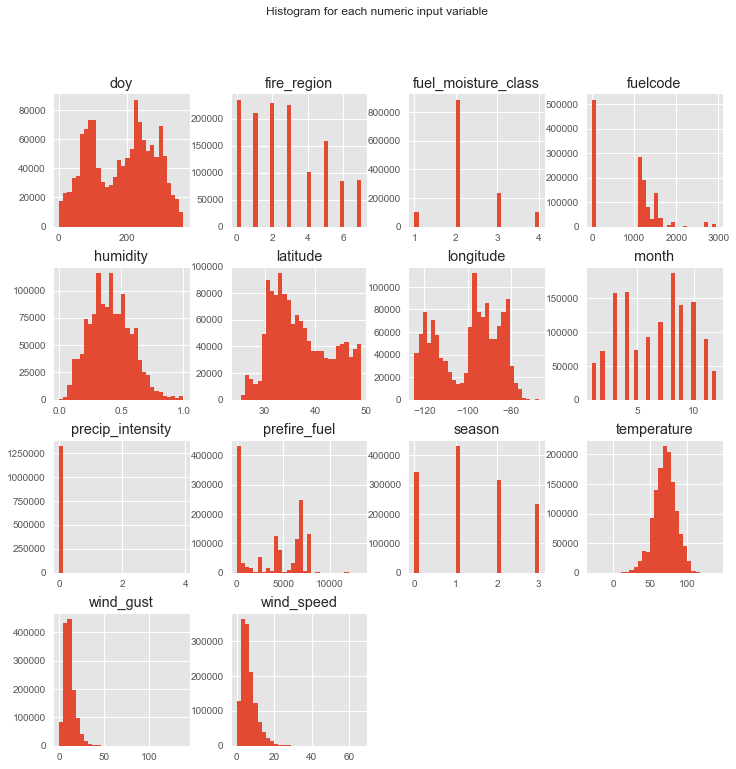

In [10]:
#historgram of all numerical data
df_fires.hist(bins=30, figsize=(12,12))
pl.suptitle("Histogram for each numeric input variable")
plt.show()

In [11]:
df_fires.columns

Index(['latitude', 'longitude', 'doy', 'month', 'fire_region', 'season',
       'fuelcode', 'prefire_fuel', 'fuel_moisture_class', 'temperature',
       'humidity', 'precip_intensity', 'wind_speed', 'wind_gust',
       'fire_intensity', 'fire_intensity_twocat', 'fire_intensity_threecat',
       'fire_intensity_fourcat'],
      dtype='object')

### Set X, y for deeper feature evaluation

In [9]:
#feature we will go with
feature_names = [ 'month', 'latitude', 'longitude', 'doy','temperature', 'wind_speed','humidity', 'fire_region', 'season', 
                 'fuelcode', 'prefire_fuel', 'fuel_moisture_class',
                 'precip_intensity', 'wind_gust']


#remove negative values from fire temperature to help with certain models
# very few values here, in the final model code a scaler will be used

''' 
#use for NB does not like negative 
ind = 0

for ind in df_fires['temperature'].index:      
        if df_fires['temperature'][ind] < 0:
            df_fires['temperature'][ind] = 0
'''

X = df_fires[feature_names]
y = df_fires['fire_intensity_twocat']

### We have very unbalance bins - let's use SMOTE to make things a little more equal

After much trial and error oversampling the data in any form did not produce better results and most often worse results.
Decide instead to only undersample the data. Produced best results. 

In [11]:
def smote_data(X, y):
    
    
    under_range = {'Moderate' :75000}
    under = RandomUnderSampler(sampling_strategy=under_range)
    X, y = under.fit_resample(X,y)

    return X, y



In [12]:
X, y = smote_data(X,y)

In [13]:
print(y.size)

92493


### Ensure y is transformed to numerical value

In [14]:
y = LabelEncoder().fit_transform(y)

### Visualize the multicolinearity of features
This model is fairly good, wind or windgust can be considered for removing but may keep 
as we believe both play a hugh role in wildfires

Month can likely be dropped. Fuelcode and prefire fuel are different as one is a label and the other is continous measure of fuel. Fuel code will be one hot encoded in the ML. 

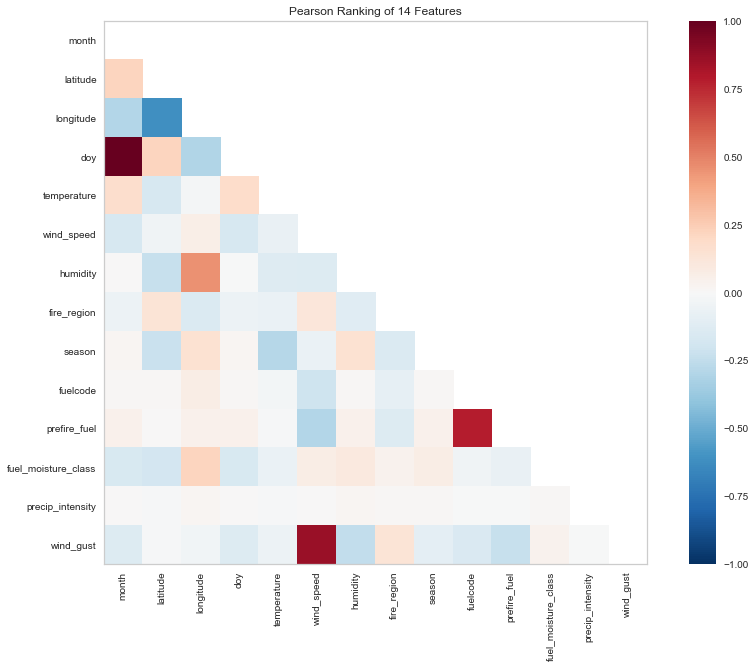

In [15]:
from yellowbrick.features import Rank2D

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', features=feature_names, size=(1080, 720))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

### Show which features likely have the most impact in RadViz
Slight skew toward doy and longitude

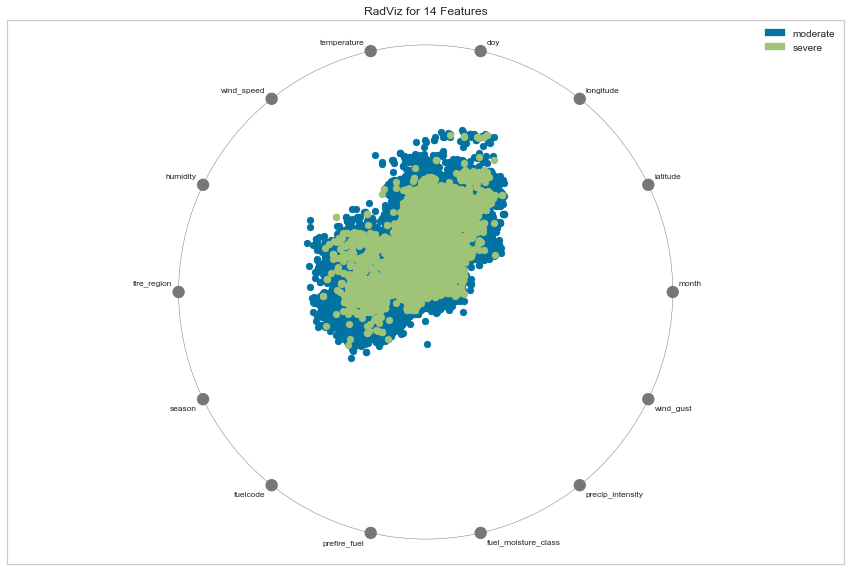

In [16]:
# Specify the target classes
classes = ["moderate", "severe"]

# Instantiate the visualizer
visualizer = RadViz(classes=classes, features=feature_names, size=(1080, 720))

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show()              # Draw the data

### Show Random forest classier of the most important features to predict severity

<i>  Answers differ on run but Top and bottom half are consistent though. Run 3-4 times to get a feel </i>
Recommend to remove season and region as they are represented in other features. Also remove precip_intensity.

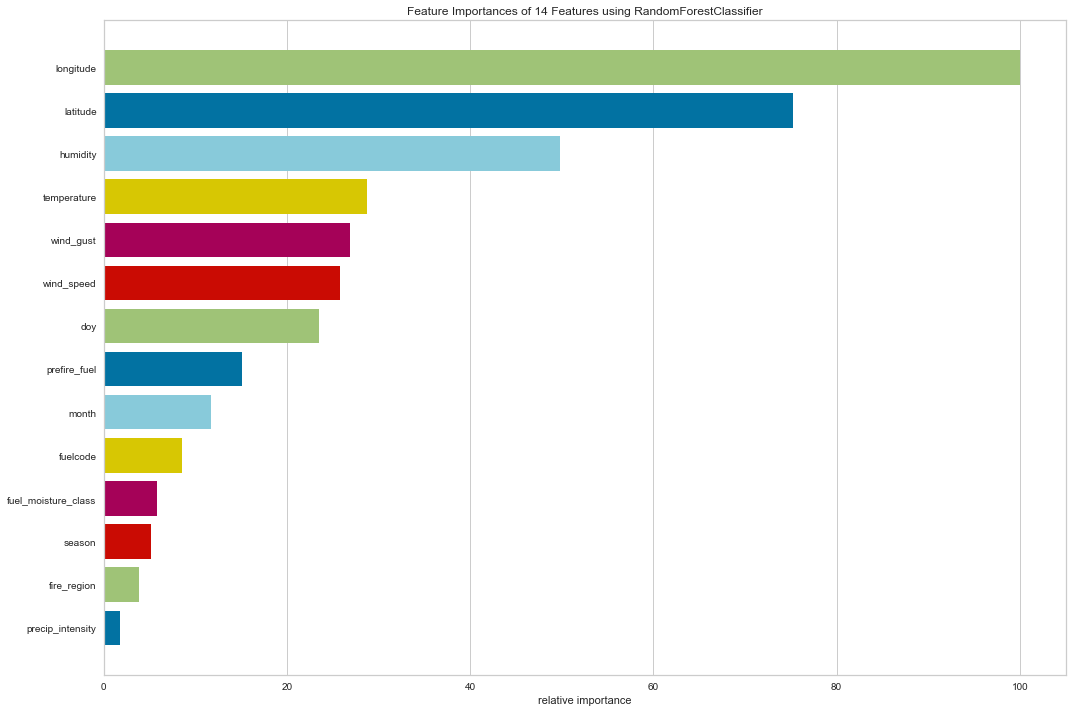

In [17]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

model = RandomForestClassifier(n_estimators=5)
viz = FeatureImportances(model, labels=feature_names, size=(1080, 720))

viz.fit(X, y)
viz.show()

In [2]:
#feature we will go with

feature_names = [ 'latitude', 'longitude', 'doy','temperature', 'wind_speed','humidity',  
                 'fuelcode', 'prefire_fuel', 'fuel_moisture_class',
                 'precip_intensity']
'''

#model without lat, lon, day of year
feature_names = [ 'temperature', 'wind_speed','humidity', 'fire_region', 'season', 
                 'fuelcode', 'prefire_fuel', 'fuel_moisture_class',
                 'precip_intensity', 'wind_gust']

#check out model with no weather data
feature_names = ['fire_region', 'season', 
                 'fuelcode', 'prefire_fuel', 'fuel_moisture_class']

#remove negative values from fire temperature to help with certain models
# very few values here, in the final model code a scaler will be used
ind = 0

# use for NB does not like negative 
for ind in df_fires['temperature'].index:      
        if df_fires['temperature'][ind] < 0:
            df_fires['temperature'][ind] = 0
'''

X = X[feature_names]
#y = df_fires['fire_intensity_fourcat']
#y = LabelEncoder().fit_transform(y)

NameError: name 'df_fires' is not defined

### Let's Check the learning Curve on different models
First setup the intial variables

In [18]:
# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=10)
sizes = np.linspace(0.3, 1.0, 10)


### Instantiate Multi NB
Not a great F1 score
Too much data causes a memory leak for NB

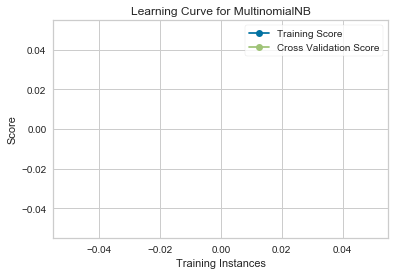

In [19]:
# Perform 80/20 training/test split to split up the data quickly
X_train, X_test, y_train, y_test = tts(
        X, y, test_size=0.20, random_state=42)


model = MultinomialNB()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=10
)

visualizer.fit(X_test, y_test)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

### Instantiate Multi SVC
Not a great F1 score. Removed from Notebook takes a long time to run, complex.

### Instantiate Bagging Classifier
Good F1 score - worth fine tuning data and hyper parameters

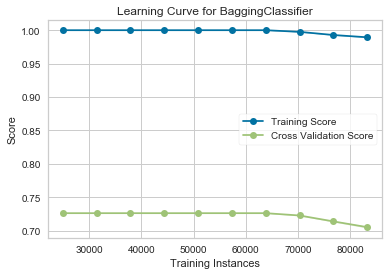

In [21]:
model = BaggingClassifier()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

     

#### Instantiate ExtraTrees
Good F1 score - worth fine tuning data and hyper parameters 
Extra trees fall offs at 225K for optimal data for training.  

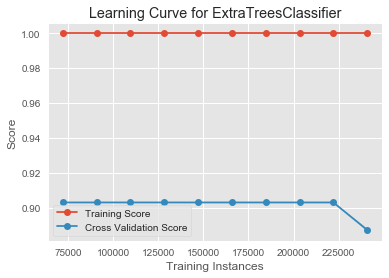

In [24]:
# Instantiate the classification model and visualizer
model = ExtraTreesClassifier(n_estimators=5)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

  

### Instantiate Random ForestClassifier
Good F1 score - worth fine tuning data and hyper parameters

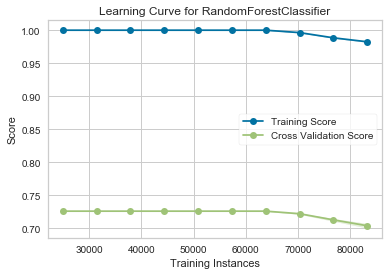

In [20]:
# Instantiate the classification model and visualizer
model = RandomForestClassifier(n_estimators=5)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure


### Instantiate AdaBoostClassifier

Not a great F1 score can skip 

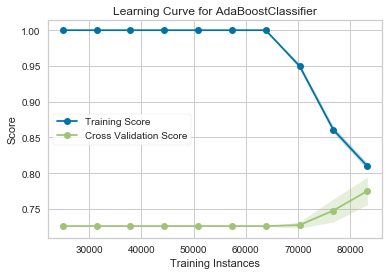

In [22]:
model = AdaBoostClassifier()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

## Final recommendation for further investigation in model tuning notebook

Features: X: [ 'temperature', 'wind_speed', 'humidity', 'fire_region', 'season', 
                 'fuelcode', 'prefire_fuel', 'fuel_moisture_class',
                 'fire_intensity_fourcat', 'wind_gust']
    
    
Models: Bagging, ExtraTrees, RandomForest